In [84]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datasets import load_dataset
from einops import rearrange
from utils import get_separated_activations, flattened_idx_to_layer_head
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [85]:
head_wise_activations = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
labels = np.load('/data/jxf/activations/llama_7B_tqa_mc2_all_labels.npy')
tokens = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_tokens.pkl', 'rb'))
num_heads = 32
head_wise_activations = rearrange(head_wise_activations, 'b l (h d) -> b l h d', h = num_heads)

In [86]:
separated_head_wise_activations, separated_labels, idxs_to_split_at = get_separated_activations(labels, head_wise_activations)

Found cached dataset truthful_qa (/data/wtl/hf_cache/truthful_qa/multiple_choice/1.1.0/63502f6bc6ee493830ce0843991b028d0ab568d221896b2ee3b8a5dfdaa9d7f4)
100%|██████████| 1/1 [00:00<00:00, 571.12it/s]


In [87]:
print(len(separated_head_wise_activations)) # fix -> 817
print(separated_head_wise_activations[0].shape)
print(separated_labels[:5])

818
(4, 32, 32, 128)
[[1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0]]


In [93]:
head_wise_activation_directions = np.array([a[np.array(l) == 1].mean(axis=0) - a[np.array(l) == 0].mean(axis=0) for a, l in zip(separated_head_wise_activations, separated_labels)])

In [94]:
head_wise_activation_directions.shape

(817, 32, 32, 128)

# 聚类可视化观察

/data/wtl/anaconda3/envs/iti/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


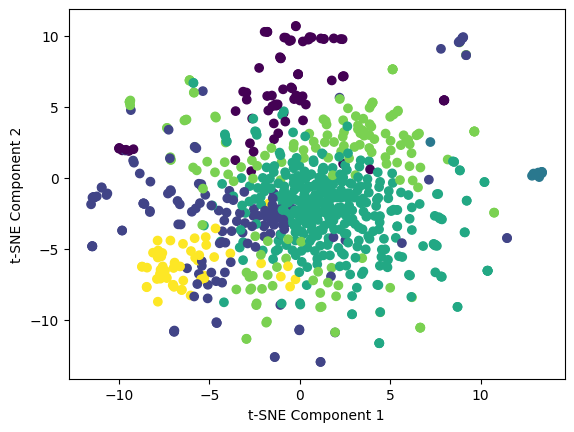

In [54]:
# 每个问题的activation保留所有维度做t-SNE

# Perform clustering
num_questions = head_wise_activation_directions.shape[0]
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(head_wise_activation_directions.reshape(num_questions, -1))

# Apply t-SNE on the clustered data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(head_wise_activation_directions.reshape(num_questions, -1))

# Plot the clustered points
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


/data/wtl/anaconda3/envs/iti/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


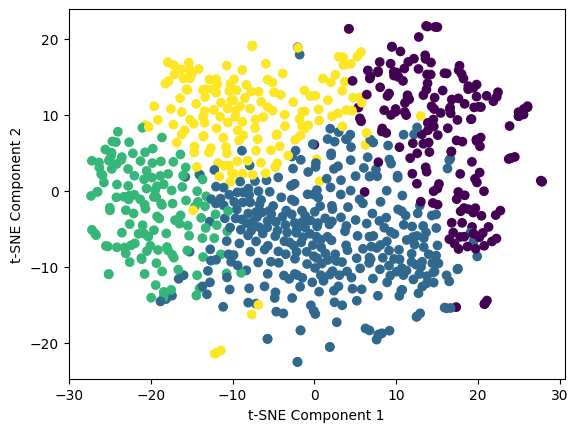

In [99]:
# 针对activation的特定layer和head做pca

layer = 12
head = 6
# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(head_wise_activation_directions[:, layer, head, :])

# Apply t-SNE on the clustered data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(head_wise_activation_directions[:, layer, head, :])

# Plot the clustered points
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [114]:
# 根据探针准确率最高的head做pca

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def get_top_heads(X, y, num_layers, num_heads, num_to_intervene):

    all_head_accs = []

    train_set_idxs = np.random.choice(range(len(y)), size=int(len(X) * 0.8), replace=False)
    val_set_idxs = np.array([x for x in range(len(y)) if x not in train_set_idxs])

    all_X_train = np.concatenate([X[i] for i in train_set_idxs], axis = 0)
    all_X_val = np.concatenate([X[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([y[i] for i in train_set_idxs], axis = 0)
    y_val = np.concatenate([y[i] for i in val_set_idxs], axis = 0)
    
    for layer in tqdm(range(num_layers), desc='train probes'): 
        for head in range(num_heads): 
            X_train = all_X_train[:,layer,head,:]
            X_val = all_X_val[:,layer,head,:]

            clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
            y_pred = clf.predict(X_train)
            y_val_pred = clf.predict(X_val)
            all_head_accs.append(accuracy_score(y_val, y_val_pred))

    all_head_accs_np = np.array(all_head_accs)
    top_accs = np.argsort(all_head_accs_np.reshape(num_heads*num_layers))[::-1][:num_to_intervene] # 排序后反转取索引
    top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_accs]  # 准确率最高的层和head的索引
    print("top accs", all_head_accs_np[top_accs])
    return top_heads

top_heads = get_top_heads(separated_head_wise_activations, separated_labels, 32, 32, 32*32)
top_heads

train probes: 100%|██████████| 32/32 [00:25<00:00,  1.26it/s]

top accs [0.82422204 0.81749369 0.81328848 ... 0.55592935 0.55592935 0.55508831]


[(11, 0),
 (11, 8),
 (11, 6),
 (10, 1),
 (14, 18),
 (9, 20),
 (11, 3),
 (18, 9),
 (11, 21),
 (18, 17),
 (10, 22),
 (15, 20),
 (10, 17),
 (11, 31),
 (14, 14),
 (14, 30),
 (13, 22),
 (16, 26),
 (24, 20),
 (13, 11),
 (18, 0),
 (17, 1),
 (17, 21),
 (14, 22),
 (16, 1),
 (11, 29),
 (10, 28),
 (15, 28),
 (10, 2),
 (13, 30),
 (14, 12),
 (5, 14),
 (13, 16),
 (12, 3),
 (6, 28),
 (13, 23),
 (20, 30),
 (20, 9),
 (7, 23),
 (9, 29),
 (19, 9),
 (12, 14),
 (16, 13),
 (12, 25),
 (18, 10),
 (12, 9),
 (22, 13),
 (14, 0),
 (16, 10),
 (12, 2),
 (15, 24),
 (8, 20),
 (16, 2),
 (14, 4),
 (11, 15),
 (7, 14),
 (10, 9),
 (8, 5),
 (13, 17),
 (7, 5),
 (16, 17),
 (9, 19),
 (6, 1),
 (20, 21),
 (18, 27),
 (14, 20),
 (12, 21),
 (21, 29),
 (8, 15),
 (16, 4),
 (21, 22),
 (14, 5),
 (9, 11),
 (7, 31),
 (19, 6),
 (10, 7),
 (31, 26),
 (22, 4),
 (26, 14),
 (8, 12),
 (10, 12),
 (31, 19),
 (19, 17),
 (17, 31),
 (22, 18),
 (31, 6),
 (10, 29),
 (16, 25),
 (7, 27),
 (9, 1),
 (17, 20),
 (20, 19),
 (25, 13),
 (12, 12),
 (22, 11),
 

/data/wtl/anaconda3/envs/iti/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


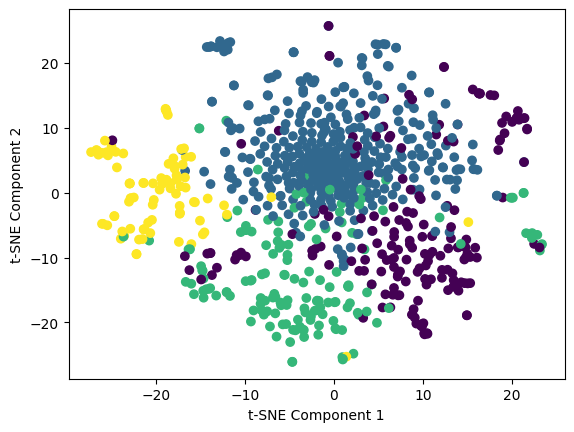

In [124]:
top_head_directions = []
for question in range(len(head_wise_activation_directions)):
    cur_top_head_directions = []
    for layer, head in np.array(top_heads)[:48]:
        cur_top_head_directions.append(head_wise_activation_directions[question, layer, head, :])
    top_head_directions.append(np.array(cur_top_head_directions).mean(axis=0))

top_head_directions = np.array(top_head_directions)

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(top_head_directions)

# Apply t-SNE on the clustered data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(top_head_directions)

# Plot the clustered points
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## 保存directions

In [125]:
import os
os.makedirs('/data/wtl/honest_llm/directions', exist_ok=True)
np.save('/data/wtl/honest_llm/directions/head_wise_activation_directions.npy', head_wise_activation_directions)